In [ ]:
import numpy as np
import pandas as pd
pd.options.display.max_columns = 12
pd.options.display.max_rows = 24

In [ ]:
import os
import warnings
import pandas_datareader as web
import datetime as dt

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot

In [ ]:
import seaborn as sns
sns.set()

In [ ]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

data preprocessing

In [ ]:
train.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [ ]:
test.head()

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1


In [ ]:
train.date.max()

'2017-12-31'

In [ ]:
train.date.min()

'2013-01-01'

In [ ]:
test["date"] = pd.to_datetime(test["date"])

In [ ]:
train["date"] = pd.to_datetime(train["date"])

In [ ]:
train.dtypes

date     datetime64[ns]
store             int64
item              int64
sales             int64
dtype: object

In [ ]:
test.dtypes

id                int64
date     datetime64[ns]
store             int64
item              int64
dtype: object

In [ ]:
lag_size = (test['date'].max().date() - train['date'].max().date()).days
lag_size

90

In [ ]:
train.isnull().sum()

date     0
store    0
item     0
sales    0
dtype: int64

In [ ]:
test.isnull().sum()

id       0
date     0
store    0
item     0
dtype: int64

split into test and train

In [ ]:
training_data = train[(train['date'] <= '2016')]
test_data = train[(train['date'] >= '2017')]

training_data.sort_values('date', inplace=True)
training_data = training_data.groupby('date')
training_data = training_data.agg({'sales':'mean'})
training_data.columns = ['sales']

test_data.sort_values('date', inplace=True)
test_data = test_data.groupby('date')
test_data = test_data.agg({'sales':'mean'})
test_data.columns = ['sales']

print(len(training_data))
print(len(test_data))

1096
365


<Axes: xlabel='date'>

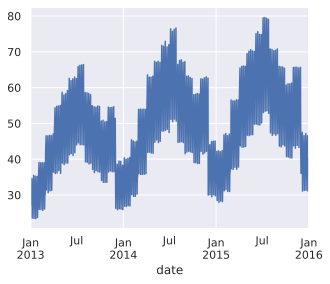

In [ ]:
training_data['sales'].plot()

<Axes: xlabel='date'>

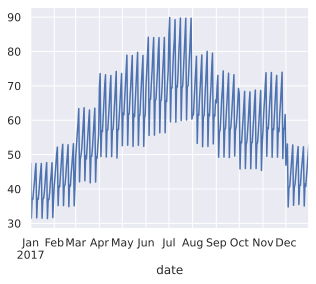

In [ ]:
test_data['sales'].plot()

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_tain_data = scaler.fit_transform(training_data.values.reshape(-1,1))
scaled_tain_data.shape

(1096, 1)

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_test_data = scaler.fit_transform(test_data.values.reshape(-1,1))
scaled_test_data.shape

(365, 1)

In [ ]:
days_past = 30
days_future = 5

In [ ]:
def split_sequence(sequence, n_past, n_future):
    X, y = [], []
    for i in range(len(sequence) - n_past - n_future + 1):
        X.append(sequence[i:i + n_past])
        y.append(sequence[i + n_past:i + n_past + n_future])
    return np.array(X), np.array(y)

In [ ]:
x_train, y_train = split_sequence(scaled_tain_data, days_past, days_future)
x_test, y_test = split_sequence(scaled_test_data, days_past, days_future)

In [ ]:
x_train.shape

(1062, 30, 1)

In [ ]:
x_test.shape

(331, 30, 1)

In [ ]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], 1))

x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], 1))

In [ ]:
x_train.shape

(1062, 30, 1)

In [ ]:
x_test.shape

(331, 30, 1)

build LSTM encoder-decoder model

In [ ]:
def DF_model():
  model = Sequential()
  model.add(LSTM(100, activation='relu',input_shape = (days_past,1)))
  model.add(Dropout(0.2))
  model.add(RepeatVector(days_future))
  model.add(LSTM(100, activation='relu', return_sequences=True))
  model.add(Dropout(0.2))
  model.add(TimeDistributed(Dense(units=1, activation = "linear")))
  return model

In [ ]:
model = DF_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 100)               40800     
                                                                 
 dropout_4 (Dropout)         (None, 100)               0         
                                                                 
 repeat_vector_2 (RepeatVect  (None, 5, 100)           0         
 or)                                                             
                                                                 
 lstm_5 (LSTM)               (None, 5, 100)            80400     
                                                                 
 dropout_5 (Dropout)         (None, 5, 100)            0         
                                                                 
 time_distributed_2 (TimeDis  (None, 5, 1)             101       
 tributed)                                            

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics = ['accuracy'])

In [ ]:
checkpointer = ModelCheckpoint(filepath = './checkpoint.hdf5', monitor='accuracy', verbose = 0, save_best_only = True)
his=model.fit(x_train,y_train,epochs=50,callbacks=[checkpointer], verbose=1)

Epoch 1/50
34/34 [==============================] - 4s 32ms/step - loss: 0.1077 - accuracy: 1.8832e-04
Epoch 2/50
34/34 [==============================] - 2s 52ms/step - loss: 0.0409 - accuracy: 7.5330e-04
Epoch 3/50
34/34 [==============================] - 2s 51ms/step - loss: 0.0255 - accuracy: 9.4162e-04
Epoch 4/50
34/34 [==============================] - 1s 32ms/step - loss: 0.0201 - accuracy: 9.4162e-04
Epoch 5/50
34/34 [==============================] - 1s 34ms/step - loss: 0.0186 - accuracy: 9.4162e-04
Epoch 6/50
34/34 [==============================] - 1s 33ms/step - loss: 0.0187 - accuracy: 9.4162e-04
Epoch 7/50
34/34 [==============================] - 1s 31ms/step - loss: 0.0181 - accuracy: 9.4162e-04
Epoch 8/50
34/34 [==============================] - 1s 32ms/step - loss: 0.0181 - accuracy: 9.4162e-04
Epoch 9/50
34/34 [==============================] - 1s 32ms/step - loss: 0.0178 - accuracy: 9.4162e-04
Epoch 10/50
34/34 [==============================] - 1s 33ms/step - loss:

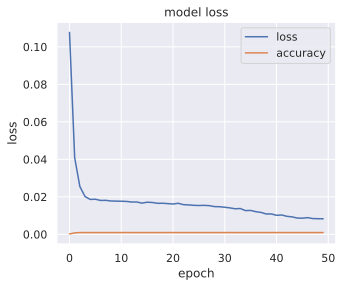

In [ ]:
plt.plot(his.history['loss'])
plt.plot(his.history['accuracy'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss','accuracy'])
plt.show()

In [ ]:
predicted_sales = model.predict(x_test)

11/11 [==============================] - 0s 11ms/step


In [ ]:
predicted_sales

array([[[0.1384146 ],
        [0.15555389],
        [0.18524249],
        [0.21825835],
        [0.2501393 ]],

       [[0.15886003],
        [0.18782264],
        [0.21787855],
        [0.24230406],
        [0.25822836]],

       [[0.20243134],
        [0.22932708],
        [0.23161677],
        [0.20331441],
        [0.15152448]],

       ...,

       [[0.1850003 ],
        [0.22572774],
        [0.26924255],
        [0.31091276],
        [0.3490458 ]],

       [[0.19699591],
        [0.245298  ],
        [0.2892756 ],
        [0.32815507],
        [0.3640892 ]],

       [[0.21907082],
        [0.2703748 ],
        [0.31158257],
        [0.3269501 ],
        [0.31011865]]], dtype=float32)

In [ ]:
y_test = scaler.inverse_transform(np.squeeze(y_test))
predicted_sales = scaler.inverse_transform(np.squeeze(predicted_sales))

In [ ]:
y_test = y_test.flatten()
predicted_sales = predicted_sales.flatten()

In [ ]:
predicted_sales

array([39.48821 , 40.49048 , 42.22661 , ..., 49.614727, 50.513386,
       49.529118], dtype=float32)

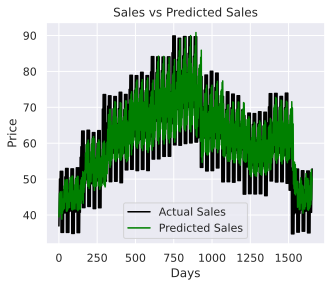

In [ ]:
plt.plot(y_test, color='black', label=f"Actual Sales")
plt.plot(predicted_sales, color= 'green', label="Predicted Sales")
plt.title("Sales vs Predicted Sales")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.show()